# Day 8 - Lab 1: Vision-Enabled UI/UX Agents

**Objective:** Use multi-modal vision models to generate a frontend UI from a design image, and then use a second agent to perform an automated design review.

**Estimated Time:** 90 minutes

**Introduction:**
Welcome to Day 8! Today, we'll explore one of the most exciting advancements in AI: vision. We will use a vision-capable model to act as a frontend developer, translating a design image directly into code. Then, we will create a second "UI/UX Critic" agent to automate the design review process, demonstrating a complete, AI-assisted frontend workflow.

For definitions of key terms used in this lab, please refer to the [GLOSSARY.md](../../GLOSSARY.md).

## Step 1: Setup

For this lab, we need to ensure we are using a vision-capable model. We will configure our `utils.py` helper to use a model like OpenAI's `gpt-4o` or Google's `gemini-2.5-pro`.

**Model Selection:**
This lab requires a vision-capable model. Excellent choices include `gpt-4o`, `gemini-2.5-pro`, or `deepseek-ai/DeepSeek-VL2`.

**Helper Functions Used:**
- `setup_llm_client()`: To configure the API client.
- `get_vision_completion()`: A specialized function to send an image and a text prompt to a vision model.
- `get_completion()`: To send text-only prompts for the refactoring step.
- `save_artifact()`: To save the generated code and the design review.

In [1]:
import sys
import os

# Add the project's root directory to the Python path
try:
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
except IndexError:
    project_root = os.path.abspath(os.path.join(os.getcwd()))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils import setup_llm_client, get_vision_completion, get_image_generation_completion, get_completion, save_artifact, clean_llm_output, recommended_models_table
from IPython.display import Image, display, Code

# Use Gemini-2.5 for all tasks
image_client, image_model_name, image_api_provider = setup_llm_client(model_name="gemini-2.5-flash-text")
print(f"✅ Using {image_model_name} for image generation")

image_editing_client, image_editing_model_name, image_editing_api_provider = setup_llm_client(model_name="gemini-2.5-flash-image")
print(f"✅ Using {image_editing_model_name} for image editing")

vision_client, vision_model_name, vision_api_provider = setup_llm_client(model_name="gemini-2.5-image-edit")
print(f"✅ Using {vision_model_name} for vision tasks")

if not image_model_name or not vision_model_name:
    print("Could not set up a valid LLM client. Please check your .env file and utils.py configuration.")

2025-09-30 15:06:24,761 ag_aisoftdev.utils INFO LLM Client configured provider=google model=gemini-2.5-flash-text latency_ms=None artifacts_path=None


✅ Using gemini-2.5-flash-text for image generation


2025-09-30 15:06:29,921 ag_aisoftdev.utils INFO LLM Client configured provider=google model=gemini-2.5-flash-image latency_ms=None artifacts_path=None


✅ Using gemini-2.5-flash-image for image editing


2025-09-30 15:06:30,908 ag_aisoftdev.utils INFO LLM Client configured provider=google model=gemini-2.5-image-edit latency_ms=None artifacts_path=None


✅ Using gemini-2.5-image-edit for vision tasks


In [2]:
recommended_models_table()

| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |
|---|---|---|---|---|---|---|---|---|
| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| claude-opus-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| claude-sonnet-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |
| dall-e-3 | openai | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |
| gemini-1.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 8,192 |
| gemini-1.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 2,000,000 | 8,192 |
| gemini-2.0-flash-exp | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 8,192 |
| gemini-2.0-flash-preview-image-generation | google | ❌ | ❌ | ✅ | ❌ | ❌ | 32,000 | 8,192 |
| gemini-2.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-flash-image-preview | google | ❌ | ❌ | ✅ | ❌ | ❌ | 32,768 | 32,768 |
| gemini-2.5-flash-lite | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-live-2.5-flash-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,048,576 | 8,192 |
| gpt-4.1 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,768 |
| gpt-4.1-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,000 |
| gpt-4.1-nano | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,000 |
| gpt-4o | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-4o-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-5-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| gpt-5-mini-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| gpt-5-nano-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| meta-llama/Llama-3.3-70B-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 8,192 | 4,096 |
| meta-llama/Llama-4-Maverick-17B-128E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |
| meta-llama/Llama-4-Scout-17B-16E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 10,000,000 | 100,000 |
| mistralai/Mistral-7B-Instruct-v0.3 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 32,768 | 8,192 |
| o3 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| o4-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| stabilityai/stable-diffusion-3.5-large | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| tokyotech-llm/Llama-3.1-Swallow-8B-Instruct-v0.5 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 4,096 | 1,024 |
| veo-3.0-fast-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| veo-3.0-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| whisper-1 | openai | ❌ | ❌ | ❌ | ❌ | ✅ | - | - |

'| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |\n|---|---|---|---|---|---|---|---|---|\n| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |\n| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |\n| claude-opus-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |\n| claude-sonnet-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |\n| dall-e-3 | openai | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |\n| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |\n| gemini-1.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 8,192 |\n| gemini-1.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 2,000,000 | 8,192 |\n| gemini-2.0-flash-exp | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 8,192 |\n| gemini-2.0-flash-preview

## Step 2: The Design Screenshot

This is the design we want our AI agent to build. It's a simple login form component. We will provide the URL to this image directly to the model.

In [3]:
# --- Onboarding Dashboard Design Generation ---
screen_generation_prompt = (
    "A modern onboarding dashboard for employees. "
    "Professional, clean, and visually appealing. "
    "White background, soft blue accents, rounded corners, subtle drop shadows. "
    "Header bar with company logo left, 'Employee Onboarding Dashboard' center. "
    "Left sidebar with icons for navigation. "
    "Main area: "
    "- Top: Circular profile photo, employee name, job title, department. "
    "- Center: Large horizontal progress bar showing onboarding completion. "
    "- Below: Three cards for onboarding steps (Submit Documents, Complete Training, Meet Your Team), each with status icon (check, clock, exclamation). "
    "- Right: Welcome message with friendly illustration. "
    "- Bottom: Quick links as pill-shaped buttons (HR Policies, IT Setup, Benefits). "
    "Notification bell icon top right for pending tasks. "
    "Minimalist, lots of whitespace, easy to read, responsive for desktop and mobile. "
    "No unnecessary decorations. "
    "Flat design, clear visual hierarchy, accessible color palette, readable sans-serif font."
)

# Use Gemini-2.5-flash-image for text-to-image generation
image_client, image_model_name, image_api_provider = setup_llm_client(model_name="gemini-2.5-flash-image")
file_path, image_url = None, None
if not image_client:
    print(f"❌ Image generation error: API client not initialized for {image_model_name}. Please check your .env file, credentials, and setup_llm_client configuration.")
else:
    print(f"Using {image_model_name} for image generation...")
    file_path, image_url = get_image_generation_completion(screen_generation_prompt, image_client, image_model_name, image_api_provider)
    # Display the generated image if successful
    if file_path and image_url:
        print(f"✅ Generated image saved to: {file_path}")
        display(Image(url=image_url))
    elif image_url:
        print(f"❌ Image generation failed: {image_url}")
    else:
        print("❌ Image generation returned no result")
    print("Image URL:", image_url)

2025-09-30 15:19:57,615 ag_aisoftdev.utils INFO LLM Client configured provider=google model=gemini-2.5-flash-image latency_ms=None artifacts_path=None


Using gemini-2.5-flash-image for image generation...


ClientError: 404 NOT_FOUND. {'error': {'code': 404, 'message': 'models/gemini-2.5-flash-image is not found for API version v1beta, or is not supported for predict. Call ListModels to see the list of available models and their supported methods.', 'status': 'NOT_FOUND'}}

In [4]:
recommended_models_table()

| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |
|---|---|---|---|---|---|---|---|---|
| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| claude-opus-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| claude-sonnet-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |
| dall-e-3 | openai | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |
| gemini-1.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 8,192 |
| gemini-1.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 2,000,000 | 8,192 |
| gemini-2.0-flash-exp | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 8,192 |
| gemini-2.0-flash-preview-image-generation | google | ❌ | ❌ | ✅ | ❌ | ❌ | 32,000 | 8,192 |
| gemini-2.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-flash-image-preview | google | ❌ | ❌ | ✅ | ❌ | ❌ | 32,768 | 32,768 |
| gemini-2.5-flash-lite | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-live-2.5-flash-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,048,576 | 8,192 |
| gpt-4.1 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,768 |
| gpt-4.1-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,000 |
| gpt-4.1-nano | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,000 |
| gpt-4o | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-4o-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-5-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| gpt-5-mini-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| gpt-5-nano-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| meta-llama/Llama-3.3-70B-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 8,192 | 4,096 |
| meta-llama/Llama-4-Maverick-17B-128E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |
| meta-llama/Llama-4-Scout-17B-16E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 10,000,000 | 100,000 |
| mistralai/Mistral-7B-Instruct-v0.3 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 32,768 | 8,192 |
| o3 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| o4-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| stabilityai/stable-diffusion-3.5-large | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| tokyotech-llm/Llama-3.1-Swallow-8B-Instruct-v0.5 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 4,096 | 1,024 |
| veo-3.0-fast-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| veo-3.0-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| whisper-1 | openai | ❌ | ❌ | ❌ | ❌ | ✅ | - | - |

'| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |\n|---|---|---|---|---|---|---|---|---|\n| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |\n| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |\n| claude-opus-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |\n| claude-sonnet-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |\n| dall-e-3 | openai | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |\n| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |\n| gemini-1.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 8,192 |\n| gemini-1.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 2,000,000 | 8,192 |\n| gemini-2.0-flash-exp | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 8,192 |\n| gemini-2.0-flash-preview

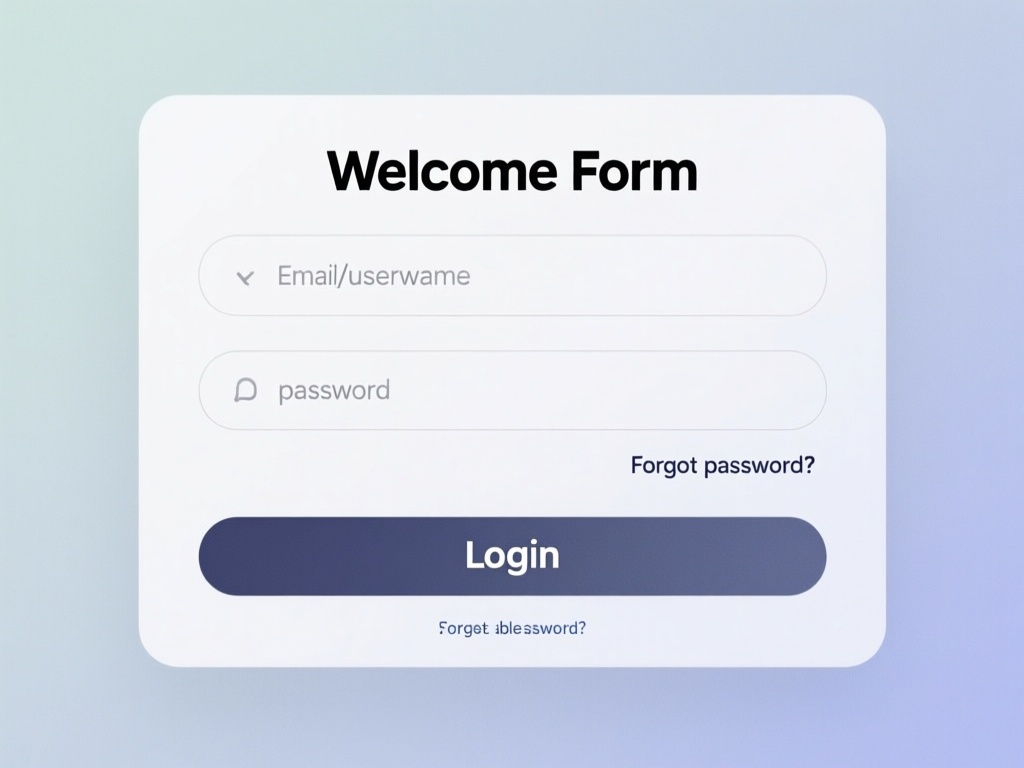

In [21]:
login_form_url = r"C:\Users\labadmin\Desktop\AG-AISOFTDEV\artifacts\screens\image_1759253144.png"
display(Image(filename=login_form_url))

## Step 3: The Challenges

### Challenge 1 (Foundational): Generating a Monolithic UI Component

**Task:** Use the vision model to generate a single, self-contained React component that replicates the design from the image.

> **Tip for Vision Prompts:** Be specific about the output format. Telling the model you want 'React' and 'Tailwind CSS' is crucial. The more specific your technical constraints, the better the generated code will be.

**Instructions:**
1.  Create a prompt that asks the vision model to act as an expert frontend developer.
2.  The prompt should instruct the model to analyze the image at the provided URL.
3.  Ask it to generate a single React component using Tailwind CSS for styling.
4.  The output should be a single block of JSX code.

**Expected Quality:** A single file's worth of React code that, when rendered, visually approximates the login form in the screenshot.

In [22]:
# --- Direct OpenAI Vision API Call ---
import os
import requests
import base64

image_path = r"C:\Users\labadmin\Desktop\AG-AISOFTDEV\artifacts\screens\image_1759253144.png"
explain_image_prompt = """
You are an expert frontend developer and UI/UX designer. Analyze the provided image and produce a clear, actionable explanation for a developer who will implement the UI.

Please respond in markdown and include the following sections:

1) Summary: One-sentence summary of what this screen is (purpose).
2) Visual Breakdown: Enumerate the visible UI elements (e.g., header, logo, form fields, buttons, icons, images) and approximate positions (top/left/center, grouping).
3) Style Details: Describe colors, font styles (weight/size/line-height if evident), spacing, borders/radii, shadows, and alignment cues.
4) Interaction & Behavior: Identify interactive elements and the likely behaviors (hover/focus states, validation, keyboard affordances).
5) Accessibility Notes: Potential accessibility issues and recommended fixes (labels, contrast, focus order).
6) Implementation Plan (React + Tailwind): Suggest component names and a short mapping of each component to Tailwind utilities or structure (e.g., <LoginForm> -> container: flex, gap-4, ...). Keep this as a concise checklist.

Keep the output developer-focused and actionable.
"""

print("--- Requesting image explanation from OpenAI Vision API ---")
api_key = os.environ.get("OPENAI_API_KEY")
if not api_key:
    print("❌ OPENAI_API_KEY not set in environment.")
else:
    with open(image_path, "rb") as img_file:
        img_b64 = base64.b64encode(img_file.read()).decode("utf-8")
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": explain_image_prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{img_b64}"}}
                ]
            }
        ],
        "max_tokens": 1024
    }
    url = "https://api.openai.com/v1/chat/completions"
    try:
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()
        result = response.json()
        explanation = result["choices"][0]["message"]["content"]
        display(Code(explanation, language="markdown"))
        # Save the explanation for later reference
        os.makedirs("artifacts", exist_ok=True)
        with open("artifacts/image_explanation.md", "w", encoding="utf-8") as f:
            f.write(explanation)
    except Exception as e:
        print(f"❌ OpenAI Vision API error: {e}")

--- Requesting image explanation from OpenAI Vision API ---


```markdown
## 1) Summary
This screen is a login form interface designed to authenticate users by collecting their email/username and password.

## 2) Visual Breakdown
- **Header**: "Welcome Form" text at the top, centered.
- **Input Fields**: 
  - Email/Username field with an icon on the left, centered below the header.
  - Password field with an icon on the left, below the Email/Username field.
- **Links**:
  - "Forgot password?" link aligned to the right beside the password field.
- **Button**: 
  - "Login" button, centered below the input fields.
- **Background**: Soft gradient background across the entire form area.
- **Rounded Corners**: Form with slightly rounded edges.

## 3) Style Details
- **Colors**: 
  - Background: Light gradient (blue to green).
  - Text: Black for the header, darker blue for the links and button.
  - Inputs and button background: White with a subtle shadow.
- **Font**: 
  - Header is bold and larger size.
  - Input placeholders and links are smaller, standard weight.
- **Spacing**: 
  - Generous padding around inputs and button.
  - Consistent vertical spacing between elements.
- **Borders/Radii**: 
  - Input fields and button have medium radii.
- **Shadows**: 
  - Light shadow under the form for a slight float effect.
- **Alignment**: 
  - Center-aligned elements within the form container.

## 4) Interaction & Behavior
- **Inputs**:
  - Focus state likely includes border color change.
  - Validation with error messages potentially shown below.
- **Links**:
  - Hover state changes color or underline for emphasis.
- **Button**:
  - Hover state likely includes a darker background color.

## 5) Accessibility Notes
- Ensure text contrast meets WCAG guidelines for readability.
- Include aria-labels for icons in input fields.
- Proper focus indicators for keyboard navigation.
- Logical focus order: Header > Email/Username > Password > Forgot Password > Login.

## 6) Implementation Plan (React + Tailwind)
- `<LoginForm>`: 
  - `container`: `flex flex-col items-center p-8 bg-white rounded-lg shadow-lg`
- `<Header>`:
  - `text`: `text-xl font-bold mb-6`
- `<InputField>` (Email/Username):
  - `container`: `flex items-center mb-4 p-2 border rounded-md`
  - `input`: `flex-1 ml-2`
- `<InputField>` (Password):
  - `container`: `flex items-center mb-2 p-2 border rounded-md`
  - `input`: `flex-1 ml-2`
- `<Link>` ("Forgot password?"):
  - `text`: `text-sm text-blue-700 hover:underline`
- `<Button>` ("Login"):
  - `button`: `w-full py-2 mt-4 text-white bg-blue-700 rounded-md hover:bg-blue-800 focus:outline-none`

```

In [23]:
# Challenge 1: Monolithic UI Component
generate_ui_prompt = f"""
Act as an expert frontend developer. 
Analyze the image at the provided URL.
Generate a single, self-contained React component that replicates the design from the image.
Use React and Tailwind CSS for styling.
Output only a single block of JSX code.
"""

print("--- Generating Monolithic UI Component ---")
# Use direct API call instead of get_vision_completion, since vision is not implemented in this environment
import os
import requests
import base64

image_path = r"C:\Users\labadmin\Desktop\AG-AISOFTDEV\artifacts\screens\image_1759253144.png"
api_key = os.environ.get("OPENAI_API_KEY")
if not api_key:
    print("❌ OPENAI_API_KEY not set in environment.")
else:
    with open(image_path, "rb") as img_file:
        img_b64 = base64.b64encode(img_file.read()).decode("utf-8")
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": generate_ui_prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{img_b64}"}}
                ]
            }
        ],
        "max_tokens": 1024
    }
    url = "https://api.openai.com/v1/chat/completions"
    try:
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()
        result = response.json()
        generated_monolithic_code = result["choices"][0]["message"]["content"]
        cleaned_code = generated_monolithic_code  # Optionally use clean_llm_output if needed
        from IPython.display import Code, display
        display(Code(cleaned_code, language='jsx'))
        os.makedirs("artifacts", exist_ok=True)
        with open("artifacts/day8_login_monolithic.jsx", "w", encoding="utf-8") as f:
            f.write(cleaned_code)
    except Exception as e:
        print(f"❌ OpenAI Vision API error: {e}")

--- Generating Monolithic UI Component ---


```jsx
import React from 'react';

const LoginComponent = () => {
  return (
    <div className="flex items-center justify-center min-h-screen bg-gradient-to-r from-blue-100 to-purple-100">
      <div className="bg-white rounded-xl shadow-md p-8 max-w-md w-full">
        <h1 className="text-2xl font-bold text-center mb-6">Welcome Form</h1>
        <form>
          <div className="mb-4">
            <label className="sr-only" htmlFor="email">Email/username</label>
            <div className="relative">
              <input
                type="text"
                id="email"
                placeholder="Email/username"
                className="block w-full px-4 py-3 placeholder-gray-500 text-gray-900 rounded-full border border-gray-300 focus:outline-none focus:ring-2 focus:ring-blue-500"
              />
              <div className="absolute inset-y-0 left-0 flex items-center pl-3 pointer-events-none">
                <svg className="w-5 h-5 text-gray-400" fill="none" stroke="currentColor" viewBox="0 0 24 24"
                     xmlns="http://www.w3.org/2000/svg"><path strokeLinecap="round" strokeLinejoin="round"
                                                               strokeWidth="2"
                                                               d="M16 12a4 4 0 01-8 0v-3a4 4 0 018 0v3zm-4 4a4 4 0 01-4-4V9a4 4 0 018 0v3a4 4 0 01-4 4z"></path></svg>
              </div>
            </div>
          </div>
          <div className="mb-6">
            <label className="sr-only" htmlFor="password">Password</label>
            <div className="relative">
              <input
                type="password"
                id="password"
                placeholder="Password"
                className="block w-full px-4 py-3 placeholder-gray-500 text-gray-900 rounded-full border border-gray-300 focus:outline-none focus:ring-2 focus:ring-blue-500"
              />
              <div className="absolute inset-y-0 left-0 flex items-center pl-3 pointer-events-none">
                <svg className="w-5 h-5 text-gray-400" fill="none" stroke="currentColor" viewBox="0 0 24 24"
                     xmlns="http://www.w3.org/2000/svg"><path strokeLinecap="round" strokeLinejoin="round"
                                                               strokeWidth="2"
                                                               d="M12 15h.01M6 8v6a6 6 0 006 6h0a6 6 0 006-6V8a6 6 0 00-12 0z"></path></svg>
              </div>
              <a href="#" className="text-sm text-blue-600 hover:underline absolute right-0 inset-y-0 flex items-center pr-3">
                Forgot password?
              </a>
            </div>
          </div>
          <button
            type="submit"
            className="w-full py-3 text-white bg-gradient-to-r from-blue-500 to-purple-600 rounded-full text-lg font-semibold focus:outline-none focus:ring-2 focus:ring-blue-500">
            Login
          </button>
        </form>
        <p className="mt-6 text-center text-sm text-blue-600 hover:underline">Forgot password?</p>
      </div>
    </div>
  );
};

export default LoginComponent;
```

### Challenge 2 (Intermediate): Refactoring into Reusable Components

**Task:** A single, large component is not good practice. Now, prompt the LLM to refactor the monolithic code it just generated into smaller, reusable sub-components.

**Instructions:**
1.  Create a new prompt.
2.  Provide the monolithic JSX code from the previous step as context.
3.  Instruct the LLM to act as a senior frontend developer who champions clean code.
4.  Ask it to refactor the code by creating smaller, reusable components (e.g., `<StyledButton>`, `<InputWithIcon>`).
5.  The final output should be the complete code with the new, smaller components defined and used within the main `Login` component.

**Expected Quality:** A well-structured React file that demonstrates the component-based architecture, which is a fundamental best practice in modern frontend development.

In [26]:
# Challenge 2: Refactoring into Reusable Components
refactor_ui_prompt = f"""
You are a senior frontend developer who champions clean, maintainable code.
Refactor the following monolithic React component (provided below) into smaller, reusable sub-components.
- Identify logical sub-components (e.g., <StyledButton>, <InputWithIcon>, <LoginFormContainer>, etc.).
- Define each sub-component within the same file, using React and Tailwind CSS for styling.
- Replace repeated or complex JSX structures with these new components.
- Ensure the final output is a complete React file, with all new components defined and used within the main Login component.
- Do not include any explanations, only output the full code.

Monolithic JSX code to refactor:
""" + cleaned_code
print("--- Refactoring UI into Components ---")
if cleaned_code:
    refactored_code = get_completion(refactor_ui_prompt, vision_client, vision_model_name, vision_api_provider)
    cleaned_refactored_code = clean_llm_output(refactored_code, language='jsx')
    display(Code(cleaned_refactored_code, language='jsx'))
else:
    print("Skipping refactoring because monolithic code was not generated.")
    cleaned_refactored_code = ""

--- Refactoring UI into Components ---


import React from 'react';

const LoginComponent = () => {
  return (
    <LoginFormContainer>
      <h1 className="text-2xl font-bold text-center mb-6">Welcome Form</h1>
      <form>
        <InputWithIcon
          type="text"
          id="email"
          placeholder="Email/username"
          iconPath="M16 12a4 4 0 01-8 0v-3a4 4 0 018 0v3zm-4 4a4 4 0 01-4-4V9a4 4 0 018 0v3a4 4 0 01-4 4z"
        />
        <InputWithIcon
          type="password"
          id="password"
          placeholder="Password"
          iconPath="M12 15h.01M6 8v6a6 6 0 006 6h0a6 6 0 006-6V8a6 6 0 00-12 0z"
          additionalElement={<ForgotPasswordLink />}
        />
        <StyledButton type="submit">Login</StyledButton>
      </form>
      <p className="mt-6 text-center text-sm text-blue-600 hover:underline">Forgot password?</p>
    </LoginFormContainer>
  );
};

const LoginFormContainer = ({ children }) => (
  <div className="flex items-center justify-center min-h-screen bg-gradient-to-r from-blue-100 to-purple-100">
    <div className="bg-white rounded-xl shadow-md p-8 max-w-md w-full">
      {children}
    </div>
  </div>
);

const InputWithIcon = ({ type, id, placeholder, iconPath, additionalElement }) => (
  <div className="mb-4">
    <label className="sr-only" htmlFor={id}>{placeholder}</label>
    <div className="relative">
      <input
        type={type}
        id={id}
        placeholder={placeholder}
        className="block w-full px-4 py-3 placeholder-gray-500 text-gray-900 rounded-full border border-gray-300 focus:outline-none focus:ring-2 focus:ring-blue-500"
      />
      <div className="absolute inset-y-0 left-0 flex items-center pl-3 pointer-events-none">
        <svg className="w-5 h-5 text-gray-400" fill="none" stroke="currentColor" viewBox="0 0 24 24"
        xmlns="http://www.w3.org/2000/svg"><path strokeLinecap="round" strokeLinejoin="round"
                                                  strokeWidth="2" d={iconPath}></path></svg>
      </div>
      {additionalElement}
    </div>
  </div>
);

const StyledButton = ({ children, type }) => (
  <button
    type={type}
    className="w-full py-3 text-white bg-gradient-to-r from-blue-500 to-purple-600 rounded-full text-lg font-semibold focus:outline-none focus:ring-2 focus:ring-blue-500">
    {children}
  </button>
);

const ForgotPasswordLink = () => (
  <a href="#" className="text-sm text-blue-600 hover:underline absolute right-0 inset-y-0 flex items-center pr-3">
    Forgot password?
  </a>
);

export default LoginComponent;

### Challenge 3 (Advanced): The AI UI/UX Critic Agent

**Task:** Create a new "UI/UX Critic" agent. This agent will be given both the original design image and the generated code, and its job is to perform an automated design review.

**Instructions:**
1.  Create a final, complex prompt for a new agent.
2.  The prompt should instruct the agent to act as a meticulous UI/UX designer.
3.  Provide the agent with two pieces of context: the URL of the original design image and the final, refactored React code.
4.  The agent's task is to compare the code's likely rendered output to the design image and list any visual inconsistencies in spacing, font size, color, or layout.

**Expected Quality:** A critical design review in markdown format. This demonstrates a powerful AI-on-AI workflow, where one AI generates work and another AI validates it, automating a time-consuming QA step.

In [28]:
# Challenge 3: The AI UI/UX Critic Agent
import os
import requests
import base64

critic_agent_prompt = f"""
You are a meticulous UI/UX designer tasked with performing an automated design review.
Compare the following two items:
1. The original design image at the provided URL.
2. The final, refactored React code (see below).

Your job:
- Critically analyze the code's likely rendered output versus the design image.
- List any visual inconsistencies in spacing, font size, color, layout, or alignment.
- Note any accessibility issues or missing interactive affordances.
- Provide your review in markdown format, organized by issue type (e.g., Spacing, Typography, Color, Accessibility, Layout).
- Be specific and actionable, as if reporting to a frontend developer for fixes.

Refactored React code to review:
""" + cleaned_refactored_code

print("--- Invoking UI/UX Critic Agent ---")
api_key = os.environ.get("OPENAI_API_KEY")
image_path = login_form_url
if not api_key:
    print("❌ OPENAI_API_KEY not set in environment.")
elif not cleaned_refactored_code:
    print("Skipping critic agent because refactored code is not available.")
else:
    with open(image_path, "rb") as img_file:
        img_b64 = base64.b64encode(img_file.read()).decode("utf-8")
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": critic_agent_prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{img_b64}"}}
                ]
            }
        ],
        "max_tokens": 1024
    }
    url = "https://api.openai.com/v1/chat/completions"
    try:
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()
        result = response.json()
        design_review = result["choices"][0]["message"]["content"]
        from IPython.display import Code, display
        display(Code(design_review, language='markdown'))
        os.makedirs("artifacts", exist_ok=True)
        with open("artifacts/design_review.md", "w", encoding="utf-8") as f:
            f.write(design_review)
    except Exception as e:
        print(f"❌ OpenAI Vision API error: {e}")

--- Invoking UI/UX Critic Agent ---


# Design Review Report

## Spacing
- **Input Fields Spacing:** The space between the input fields and the "Forgot password?" link seems less in the design image. Reduce the bottom margin of input fields from `mb-4` to better match the design.
- **Button Margin:** The distance between the "Login" button and the input field above appears tighter in the design than in the code. Adjust the spacing accordingly.

## Typography
- **Font Size:** Verify all font sizes match design specifications, especially for headers and buttons, to ensure consistency.
- **Placeholder Text:** The placeholder text appears in `gray-500` in the code, which might not match exactly with the design's gray. Adjust if necessary.

## Color
- **Button Gradient:** Ensure the gradient colors for the button (`from-blue-500 to-purple-600`) match the design's darker blue-purple gradient.
- **Background Color:** The overall background gradient from `bg-gradient-to-r from-blue-100 to-purple-100` might need to be adjusted for a more accurate match with the design.

## Accessibility
- **Label Accessibility:** Utilize `aria-labels` or visible labels in addition to `sr-only` for enhanced screen reader support.
- **Focus States:** Ensure that focus outlines and states are clearly visible, especially for input fields and buttons, maintaining accessibility compliance.

## Layout
- **Alignment:** The "Forgot password?" link might not align exactly as in the design image. Ensure it remains horizontally aligned with the right side of the input fields.
- **Button Width:** The "Login" button should use a `block` display to span the full width available, replicating the design’s full-width button.

## Other Considerations
- **Text Content:** Double-check text content for typos; note the typo in the design ("Email/userwame").
- **Interactive Affordances:** Ensure interactive elements like links and buttons have appropriate cursor changes (`pointer`) on hover.

By addressing these points, the final output should align more closely with the original design, providing both a visually cohesive and accessible user experience. Adjust the React component styles and layout accordingly for optimal results.

## Lab Conclusion

Fantastic! You have completed a full, end-to-end frontend development workflow using multiple AI agents. You used a vision-powered agent to generate code from a design, a refactoring agent to improve the code's structure, and a critic agent to perform an automated design review. This powerful combination of skills can dramatically accelerate the process of turning visual ideas into functional user interfaces.

> **Key Takeaway:** The workflow of **Generate -> Refactor -> Critique** is a powerful AI-assisted development pattern. Using specialized agents for each step allows you to rapidly create a first draft, improve its quality, and then automatically check it for correctness, significantly speeding up the iteration cycle.